In [1]:
devtools::install_github("WorldWeatherAttribution/rwwa")
suppressMessages(library("rwwa"))

Skipping install of 'rwwa' from a github remote, the SHA1 (9a841cf2) has not changed since last install.
  Use `force = TRUE` to force installation



# CORDEX FWI1x

# GMST trend only

In [42]:
nsamp <- 1000
rp <- 20

fl = list.files("ts", pattern = "NAM-22i_fwi1x", full.names = T)
for(fnm in fl) {
    
    gcm <- strsplit(fnm, "_")[[1]][3]
    rcm <- strsplit(fnm, "_")[[1]][4]
    
    res_fnm <- paste0("res/res-cordex_fwi1x-rel_gmst_NAM-22i_",gcm,"_",rcm)
    
    if(!file.exists(res_fnm)) {
    
        gmst_fnm <- list.files("ts", pattern = paste0("cmip5_smoothed-gsat_",gcm), full.names = T)
        nino_fnm <- list.files("ts", pattern = paste0("nino34det_cmip5_",gcm), full.names = T)

        if( (length(gmst_fnm) == 0) | (length(nino_fnm) == 0)) { next }

        df <- merge(merge(load_ts(gmst_fnm, col.names = c("year", "gmst")), load_ts(nino_fnm, col.names = c("year", "nino34_ond"))), read.csv(fnm))
        mdl <- fit_ns("gev", "shift", df, "fwi1x", "gmst", lower = F)
        
        # use model's 2023 GMST to define factual climate        
        cov_now <- df[df$year == 2025,"gmst",drop = F]
        cov_hist <- cov_now - 1.3
        cov_fut <- cov_now + 1.3

        # bootstrap results
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2050, nsamp = nsamp, di_relative = T)
        write.csv(cbind(res, data.frame(aic = aic(mdl))), res_fnm)
        
        # quick return level plots to check fit
        rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
        if(!file.exists(rlplot_fnm)) {
            png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
                plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
            }; dev.off()
        }
    }
}

In [43]:
# compile results
res <- t(sapply(list.files("res", pattern = "fwi1x-rel_gmst_", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(r) gsub(".csv","",paste0(strsplit(r, "_")[[1]][c(4:6)], collapse = "_")))
write.csv(res, "res-models_fwi1x-rel_gmst.csv")

# GMST & Nino

In [131]:
# calculate scaled Nino covariate to define factual
nino_obs <- read.csv("ts/nino34_ond.csv", col.names = c("year", "nino34_ond"))
nino_obs <- nino_obs[(nino_obs$year >= 1940) & (nino_obs$year <= 2024),]
nino_obs$nino_scaled <- scale(nino_obs$nino34_ond)
nino_2024 <- nino_obs$nino_scaled[nino_obs$year == 2024]

In [132]:
nsamp <- 1000
rp <- 20

fl = list.files("ts", pattern = "NAM-22i_fwi1x", full.names = T)
for(fnm in fl) {
    
    gcm <- strsplit(fnm, "_")[[1]][3]
    rcm <- strsplit(fnm, "_")[[1]][4]
    
    res_fnm <- paste0("res/res-cordex_fwi1x-rel_gmst+nino_NAM-22i_",gcm,"_",rcm)
    
    if(!file.exists(res_fnm)) {
    
        gmst_fnm <- list.files("ts", pattern = paste0("cmip5_smoothed-gsat_",gcm), full.names = T)
        nino_fnm <- list.files("ts", pattern = paste0("nino34det_cmip5_",gcm), full.names = T)

        if( (length(gmst_fnm) == 0) | (length(nino_fnm) == 0)) { next }
        
        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        nino <- read.table(nino_fnm, header = 1, col.names = c("year", "nino34_ond"))
        
        # standardise Nino3.4 index to have mean 0 and variance 1 during obs period
        nino_cal <- nino[(nino$year >= 1940) & (nino$year <= 2024), "nino34_ond"]
        nino$nino34_ond <- (nino$nino34_ond - mean(nino_cal)) / sd(nino_cal)
        
        # combine into single dataframe
        df <- merge(merge(gmst, nino), read.csv(fnm))
        mdl <- fit_ns("gev", "shift", df, "fwi1x", c("gmst", "nino34_ond"), lower = F)
        
        # use model's 2025 GMST to define factual climate        
        cov_now <- data.frame(gmst = df[df$year == 2025,"gmst",drop = F], nino34_ond = nino_2024)
        cov_hist <- cov_now - c(1.3, 0)
        cov_fut <- cov_now + c(1.3, 0)

        # bootstrap results
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2050, nsamp = nsamp, di_relative = T)
        nino_corr <- c(cor(df$nino34_ond, df$fwi1x), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino34_ond", "fwi1x")])[1,2]), c(0.025, 0.975), na.rm = T))                                  
        write.csv(cbind(res, t(data.frame(setNames(nino_corr, c("nino_corr_est", "nino_corr_lower", "nino_corr_upper")))), data.frame(aic = aic(mdl))), res_fnm)
        
        # quick return level plots to check fit
        rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
        if(!file.exists(rlplot_fnm)) {
            png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
                plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
            }; dev.off()
        }
    }
}

In [143]:
# compile results
res <- t(sapply(list.files("res", pattern = "fwi1x-rel_gmst\\+nino_", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(r) gsub(".csv","",paste0(strsplit(r, "_")[[1]][c(4:6)], collapse = "_")))
write.csv(res, "res-models_fwi1x-rel_gmst+nino.csv")

# CORDEX SPI-OND

# GMST + Nino

In [145]:
# calculate scaled Nino covariate to define factual
nino_obs <- read.csv("ts/nino34_ond.csv", col.names = c("year", "nino34_ond"))
nino_obs <- nino_obs[(nino_obs$year >= 1940) & (nino_obs$year <= 2024),]
nino_obs$nino_scaled <- scale(nino_obs$nino34_ond)
nino_2024 <- nino_obs$nino_scaled[nino_obs$year == 2024]

In [146]:
nsamp <- 1000
rp <- 20

fl = list.files("ts", pattern = "spi-ond_NAM", full.names = T)
for(fnm in fl) {
    
    gcm <- strsplit(fnm, "_")[[1]][3]
    
    res_fnm <- gsub("r1i1p1", "", gsub("ts", "res", gsub("spi-ond", "res-cordex_spi-ond_gmst+nino", fnm)))
    
    if(!file.exists(res_fnm)) {
    
        gmst_fnm <- list.files("ts", pattern = paste0("cmip5_smoothed-gsat_",gcm), full.names = T)
        nino_fnm <- list.files("ts", pattern = paste0("nino34det_cmip5_",gcm), full.names = T)

        if( (length(gmst_fnm) == 0) | (length(nino_fnm) == 0)) { next }

        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        nino <- read.table(nino_fnm, header = 1, col.names = c("year", "nino34_ond"))
        
        # standardise Nino3.4 index to have mean 0 and variance 1 during obs period
        nino_cal <- nino[(nino$year >= 1940) & (nino$year <= 2024), "nino34_ond"]
        nino$nino34_ond <- (nino$nino34_ond - mean(nino_cal)) / sd(nino_cal)
        
        # combine into single dataframe
        df <- merge(merge(gmst, nino), read.csv(fnm))
        mdl <- fit_ns("norm", "shift", df, "spi_ond", c("gmst", "nino34_ond"), lower = T)
        
        # use model's 2025 GMST to define factual climate        
        cov_now <- data.frame(gmst = df[df$year == 2025,"gmst",drop = F], nino34_ond = nino_2024)
        cov_hist <- cov_now - c(1.3, 0)
        cov_fut <- cov_now + c(1.3, 0)

        # bootstrap results
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2050, nsamp = nsamp, di_relative = F)
        nino_corr <- c(cor(df$nino34_ond, df$spi_ond), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino34_ond", "spi_ond")])[1,2]), c(0.025, 0.975), na.rm = T))                                  
        write.csv(cbind(res, t(data.frame(setNames(nino_corr, c("nino_corr_est", "nino_corr_lower", "nino_corr_upper")))), data.frame(aic = aic(mdl))), res_fnm)
        
        # quick return level plots to check fit
        rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
        if(!file.exists(rlplot_fnm)) {
            png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
                plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
            }; dev.off()
        }
    }
}

In [148]:
# compile results
res <- t(sapply(list.files("res", pattern = "spi-ond_gmst\\+nino_", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(r) gsub(".csv","",paste0(strsplit(r, "_")[[1]][c(4:6)], collapse = "_")))
write.csv(res, "res-models_spi-ond_gmst+nino.csv")

# GMST trend only

In [ ]:
nsamp <- 1000
rp <- 20

fl = list.files("ts", pattern = "spi-ond_NAM", full.names = T)
for(fnm in fl) {
    
    gcm <- strsplit(fnm, "_")[[1]][3]
    
    res_fnm <- gsub("r1i1p1", "", gsub("ts", "res", gsub("spi-ond", "res-cordex_spi-ond_gmst", fnm)))
    
    if(!file.exists(res_fnm)) {
    
        gmst_fnm <- list.files("ts", pattern = paste0("cmip5_smoothed-gsat_",gcm), full.names = T)
        nino_fnm <- list.files("ts", pattern = paste0("nino34det_cmip5_",gcm), full.names = T)

        if( (length(gmst_fnm) == 0) | (length(nino_fnm) == 0)) { next }

        df <- merge(merge(load_ts(gmst_fnm, col.names = c("year", "gmst")), load_ts(nino_fnm, col.names = c("year", "nino34_ond"))), read.csv(fnm))
        mdl <- fit_ns("norm", "shift", df, "spi_ond", "gmst", lower = T)
        
        # use model's 2025 GMST to define factual climate        
        cov_now <- df[df$year == 2025,"gmst",drop = F]
        cov_hist <- cov_now - 1.3
        cov_fut <- cov_now + 1.3

        # bootstrap results
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2050, nsamp = nsamp, di_relative = F)
        write.csv(res, res_fnm)
        
        # quick return level plots to check fit
        rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
        if(!file.exists(rlplot_fnm)) {
            png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
                plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
            }; dev.off()
        }
    }
}

In [36]:
# compile results
res <- t(sapply(list.files("res", pattern = "spi-ond_gmst_", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(r) gsub(".csv","",paste0(strsplit(r, "_")[[1]][c(4:6)], collapse = "_")))
write.csv(res, "res-models_spi-ond_gmst.csv")

# Drought onset (by % of climatology)

## GMST trend only

In [196]:
nsamp <- 1000
rp <- 10

fl = list.files("ts", pattern = "cordex_doy-clim", full.names = T)
for(fnm in fl) {
    
    print(fnm)
    
    # skip models with non-finite optim values - might need to come back and re-fit with linear model instead?
    if (fnm %in% c("ts/cordex_doy-clim30pc_NAM-22_CNRM-CM5_r1i1p1_CRCM5.csv", 
                   "ts/cordex_doy-clim30pc_NAM-22_HadGEM2-ES_r1i1p1_REMO2015.csv",
                   "ts/cordex_doy-clim30pc_NAM-22_HadGEM2-ES_r1i1p1_WRF.csv",
                   "ts/cordex_doy-clim30pc_NAM-44_CanESM2_r1i1p1_CRCM5.csv",
                   "ts/cordex_doy-clim30pc_NAM-44_HadGEM2-ES_r1i1p1_WRF.csv")) {next}
    
    gcm <- strsplit(fnm, "_")[[1]][4]
    
    res_fnm <- gsub("r1i1p1_", "", gsub("ts/", "res/res-", gsub("doy-clim30pc", "doy-clim30pc_gmst", fnm)))
    
    if(!file.exists(res_fnm)) {
    
        gmst_fnm <- list.files("ts", pattern = paste0("cmip5_smoothed-gsat_",gcm), full.names = T)
        nino_fnm <- list.files("ts", pattern = paste0("nino34det_cmip5_",gcm), full.names = T)

        if( (length(gmst_fnm) == 0) | (length(nino_fnm) == 0)) { next }

        df <- merge(merge(load_ts(gmst_fnm, col.names = c("year", "gmst")), load_ts(nino_fnm, col.names = c("year", "nino34_ond"))), read.csv(fnm))
        mdl <- fit_ns("norm", "shift", df, "dayofyear", "gmst", lower = F)
        
        # use model's 2025 GMST to define factual climate        
        cov_now <- df[df$year == 2025,"gmst",drop = F]
        cov_hist <- cov_now - 1.3
        cov_fut <- cov_now + 1.3
        
#         rp155 <- return_period(mdl, 155, fixed_cov = cov_now)
        rp155 <- 10

        # bootstrap results
        res <- cmodel_results(mdl, rp = rp155, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2050, nsamp = nsamp, di_relative = F)
        write.csv(cbind(res, data.frame(rp155 = rp155)), res_fnm)
        
        # quick return level plots to check fit
        rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
        if(!file.exists(rlplot_fnm)) {
            png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
                plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
            }; dev.off()
        }
    }
}

[1] "ts/cordex_doy-clim30pc_NAM-22_CNRM-CM5_r1i1p1_CRCM5.csv"
[1] "ts/cordex_doy-clim30pc_NAM-22_GFDL-ESM2M_r1i1p1_CRCM5.csv"
[1] "ts/cordex_doy-clim30pc_NAM-22_GFDL-ESM2M_r1i1p1_WRF.csv"
[1] "ts/cordex_doy-clim30pc_NAM-22_HadGEM2-ES_r1i1p1_REMO2015.csv"
[1] "ts/cordex_doy-clim30pc_NAM-22_HadGEM2-ES_r1i1p1_WRF.csv"
[1] "ts/cordex_doy-clim30pc_NAM-22_MPI-ESM-LR_r1i1p1_REMO2015.csv"
[1] "ts/cordex_doy-clim30pc_NAM-22_MPI-ESM-LR_r1i1p1_WRF.csv"
[1] "ts/cordex_doy-clim30pc_NAM-22_MPI-ESM-MR_r1i1p1_CRCM5.csv"
[1] "ts/cordex_doy-clim30pc_NAM-22_NorESM1-M_r1i1p1_REMO2015.csv"
[1] "ts/cordex_doy-clim30pc_NAM-44_CanESM2_r1i1p1_CanRCM4.csv"
[1] "ts/cordex_doy-clim30pc_NAM-44_CanESM2_r1i1p1_CRCM5.csv"
[1] "ts/cordex_doy-clim30pc_NAM-44_EC-EARTH_r3i1p1_HIRHAM5.csv"
[1] "ts/cordex_doy-clim30pc_NAM-44_HadGEM2-ES_r1i1p1_WRF.csv"


In [197]:
# compile results
res <- t(sapply(list.files("res", pattern = "doy-clim30pc_gmst_", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(r) gsub(".csv","",paste0(strsplit(r, "_")[[1]][c(4:6)], collapse = "_")))
write.csv(res, "res-models_doy-clim30pc_gmst.csv")

# Drought onset (by 7-day drop in drought code)

## GMST trend only

In [23]:
nsamp <- 10
rp <- 10

fl = list.files("ts", pattern = "cordex_dc7-doy", full.names = T)
for(fnm in fl) {
    
    print(fnm)
    
    # skip models with non-finite optim values - might need to come back and re-fit with linear model instead?
    if (fnm %in% c('ts/cordex_dc7-doy_NAM-44_HadGEM2-ES_r1i1p1_WRF.csv', 
                   'ts/cordex_dc7-doy_NAM-44_MPI-ESM-LR_r1i1p1_WRF.csv')) {next}
    
    gcm <- strsplit(fnm, "_")[[1]][4]
    
    res_fnm <- gsub("r1i1p1_", "", gsub("ts/", "res/res-", gsub("dc7-doy", "dc7-doy_gmst", fnm)))
    
    if(!file.exists(res_fnm)) {
    
        gmst_fnm <- list.files("ts", pattern = paste0("cmip5_smoothed-gsat_",gcm), full.names = T)
        nino_fnm <- list.files("ts", pattern = paste0("nino34det_cmip5_",gcm), full.names = T)

        if( (length(gmst_fnm) == 0) | (length(nino_fnm) == 0)) { next }

        df <- merge(merge(load_ts(gmst_fnm, col.names = c("year", "gmst")), load_ts(nino_fnm, col.names = c("year", "nino34_ond"))), read.csv(fnm))
        mdl <- fit_ns("norm", "shift", df, "dc_doy", "gmst", lower = F)
        
        # use model's 2025 GMST to define factual climate        
        cov_now <- df[df$year == 2025,"gmst",drop = F]
        cov_hist <- cov_now - 1.3
        cov_fut <- cov_now + 1.3
        
#         rp155 <- return_period(mdl, 155, fixed_cov = cov_now)
        rp155 <- 10

        # bootstrap results
        res <- cmodel_results(mdl, rp = rp155, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2050, nsamp = nsamp, di_relative = F)
        write.csv(cbind(res, data.frame(aic = aic(mdl))), res_fnm)
        
        # quick return level plots to check fit
        rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
        if(!file.exists(rlplot_fnm)) {
            png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
                plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
            }; dev.off()
        }
    }
}

In [28]:
df

year,gmst,nino34_ond,dc_doy
<int>,<dbl>,<chr>,<int>
1950,-0.9879122,-0.25918898,123
1951,-0.9478207,1.6549574,162
1952,-0.8913031,-0.54831886,132
1953,-0.8790827,-0.7073879,119
1954,-0.8934269,-0.51462936,128
1955,-0.9519358,-0.768383,141
1956,-0.9032383,0.6610591,136
1957,-0.8857746,-0.13507271,118
1958,-0.8647528,-1.3106976,138


In [12]:
# compile results
res <- t(sapply(list.files("res", pattern = "dc7-doy_gmst_", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(r) gsub(".csv","",paste0(strsplit(r, "_")[[1]][c(4:6)], collapse = "_")))
write.csv(res, "res-models_dc7-doy_gmst.csv")

---
# Synthesis

In [15]:
# function to fill infinite probability ratios
infer_infinite <- function(models_in) {
    
    # split out the columns for easier reference
    est <- est_n <- models_in[,1]
    l <- l_n <- models_in[,2]
    u <- u_n <- models_in[,3]
    
    # relabel where infinite best estimate / upper bound occurs
    mnames <- rownames(models_in)
    mnames <- paste0(mnames, c("*","")[is.finite(est)+1])
    mnames <- paste0(mnames, c("*","")[is.finite(u)+1])
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE BEST ESTIMATES / UPPER BOUNDS
    # get upper bound where best estimate is infinite
    u_n[!is.finite(u_n)] <- (exp(log(est) + 3 * (log(est) - log(l))))[!is.finite(u_n)]

    # get best estimate, if infinite
    if(any(is.finite(u))) {
        # if any estimated upper bounds are finite, use the maximum upper bound to infer infinite best estimates
        f_upper <- max(u[is.finite(u)])
    } else {
        # otherwise, use the maximum inferred upper bound to infer infinite best estimates
        f_upper <- max(u_n[is.finite(u_n)])
    }
    est_n[!is.finite(est_n)] <- f_upper

    # repeat estimation of upper bound using inferred best estimate
    u_n[!is.finite(u_n)] <- (exp(log(est_n) + 3 * (log(est_n) - log(l))))[!is.finite(u_n)]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE LOWER BOUNDS NOT YET IMPLEMENTED

    return(data.frame("est" = est_n, "lower" = l_n, "upper" = u_n, row.names = mnames))   
}

In [17]:
varnm <- "fwi1x-rel"; if (varnm == "fwi1x-rel") {st = "rel"} else {st = "abs"}

obs <- read.csv(paste0("res/res-obs_",varnm,"_era5.csv"), row.names = "X")
models <- read.csv(paste0("res-models_",varnm,"_gmst.csv"), row.names = "X")

In [23]:
infer_infinite(models[,grepl("proj_PR", colnames(models))]) == models[,grepl("proj_PR", colnames(models))]

,est,lower,upper
NAM-22i_CanESM2_CanRCM4,TRUE,TRUE,TRUE
NAM-22i_CanESM2_CRCM5-UQAM,TRUE,TRUE,TRUE
NAM-22i_CanESM2_RCA4,TRUE,TRUE,TRUE
NAM-22i_GFDL-ESM2M_RegCM4,TRUE,TRUE,TRUE
NAM-22i_GFDL-ESM2M_WRF,TRUE,TRUE,TRUE
NAM-22i_HadGEM2-ES_RegCM4,TRUE,TRUE,TRUE
NAM-22i_HadGEM2-ES_WRF,TRUE,TRUE,TRUE
NAM-22i_MPI-ESM-LR_CRCM5-UQAM,TRUE,TRUE,TRUE
NAM-22i_MPI-ESM-LR_RegCM4,TRUE,TRUE,TRUE
NAM-22i_MPI-ESM-LR_WRF,TRUE,TRUE,TRUE


In [24]:
synth_dI_attr <- synthesis(obs_in = obs[paste0("dI_",st,"_pi"),], models_in = models[,grepl(paste0("attr_dI.",st), colnames(models))], synth_type = st)
synth_dI_proj <- synthesis(obs_in = NA, models_in = models[,grepl(paste0("proj_dI.",st), colnames(models))], synth_type = st)

synth_PR_attr <- data.frame("x=1")#
synth_PR_attr <- synthesis(obs_in = obs["PR_pi",], models_in = infer_infinite(models[,grepl("proj_PR", colnames(models))]), synth_type = "PR")
synth_PR_proj <- synthesis(obs_in = NA, models_in = models[,grepl("proj_PR", colnames(models))], synth_type = "PR")

In [25]:
write.csv(synth_dI_attr$df, paste0("synth/synth_",varnm,"_dI-attr.csv"), row.names = F)
write.csv(synth_dI_proj$df, paste0("synth/synth_",varnm,"_dI-proj.csv"), row.names = F)
write.csv(synth_PR_attr$df, paste0("synth/synth_",varnm,"_PR-attr.csv"), row.names = F)
write.csv(synth_PR_proj$df, paste0("synth/synth_",varnm,"_PR-proj.csv"), row.names = F)

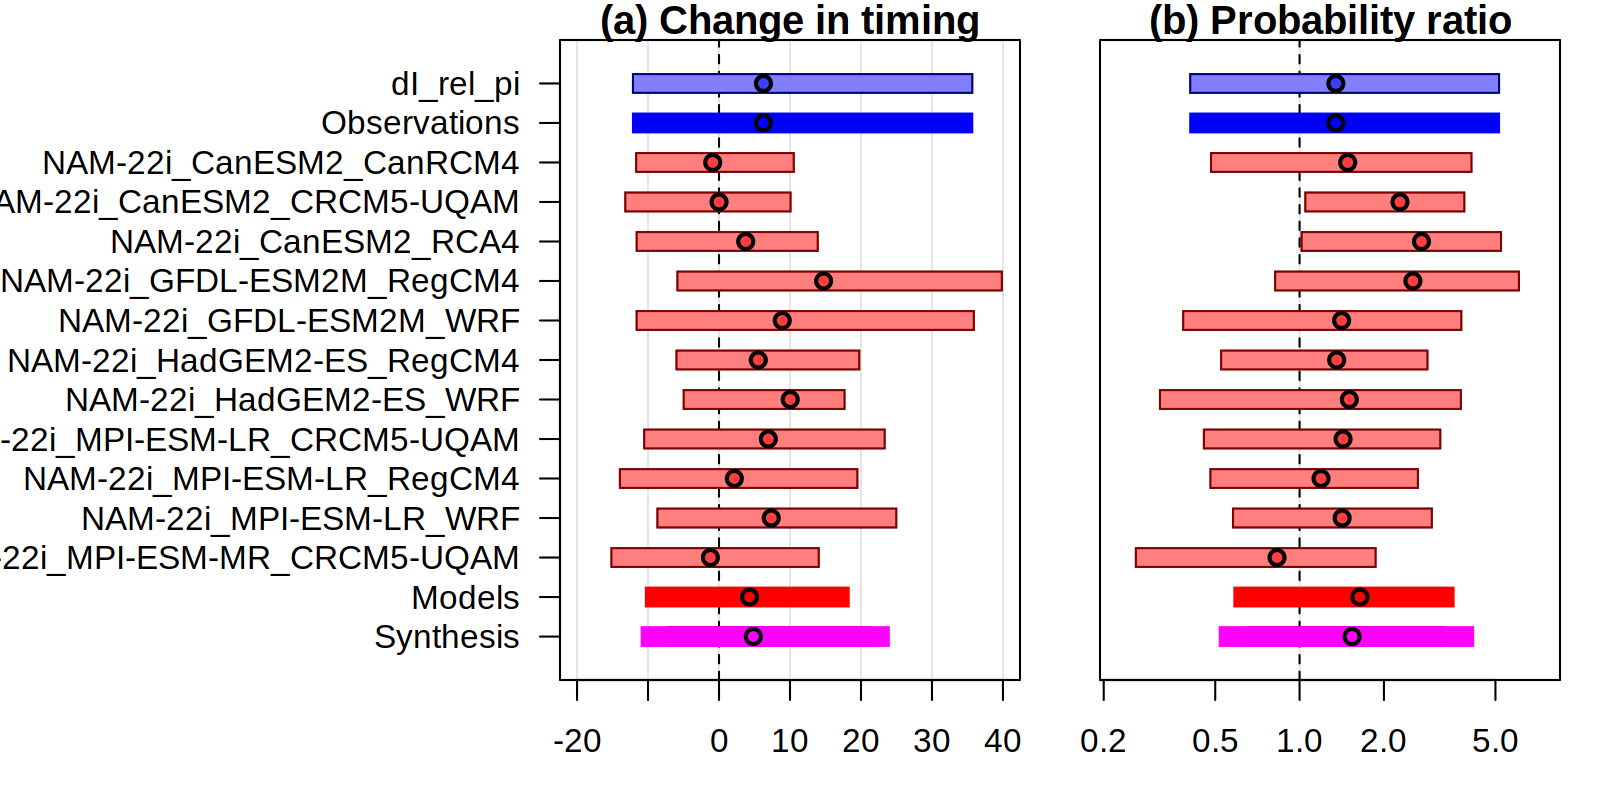

In [26]:
prep_window(c(1,2), oma = c(0,13,0,0), mar = c(3,1,1,1))
plot_synthesis(synth_dI_attr, add_space = F, main = "(a) Change in timing")
plot_synthesis(synth_PR_attr, add_space = F, hide_labels = T, main = "(b) Probability ratio")

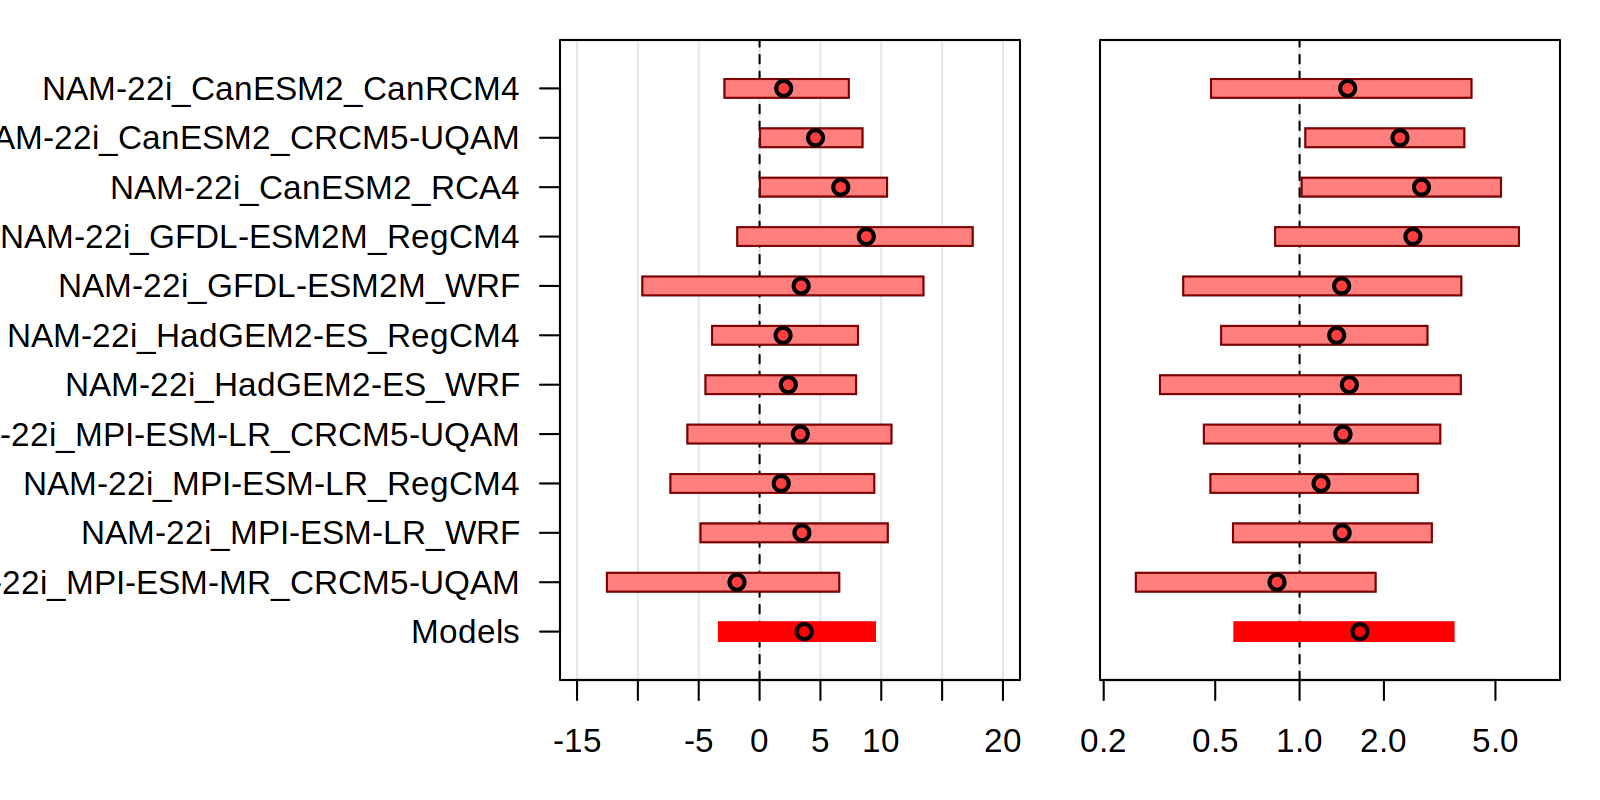

In [27]:
prep_window(c(1,2), oma = c(0,13,0,0), mar = c(3,1,1,1))
plot_synthesis(synth_dI_proj, add_space = F)
plot_synthesis(synth_PR_proj, add_space = F, hide_labels = T)